# House Prices: Advanced Regression Techniques

_Version 1: 04/27/2018_

This is an analysis of Ames, Iowa housing data set. The training and test data can be found on [kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
sns.set_palette("Set2")

%matplotlib inline

from sklearn import svm
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, KFold
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin,clone

import mord
import xgboost as xgb
import lightgbm as lgb


train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
comb = train.append(test, ignore_index=True)

Check the DataFrame for null values.

In [2]:
comb[~comb['SalePrice'].isnull()].isnull().sum()

1stFlrSF            0
2ndFlrSF            0
3SsnPorch           0
Alley            1369
BedroomAbvGr        0
BldgType            0
BsmtCond           37
BsmtExposure       38
BsmtFinSF1          0
BsmtFinSF2          0
BsmtFinType1       37
BsmtFinType2       38
BsmtFullBath        0
BsmtHalfBath        0
BsmtQual           37
BsmtUnfSF           0
CentralAir          0
Condition1          0
Condition2          0
Electrical          1
EnclosedPorch       0
ExterCond           0
ExterQual           0
Exterior1st         0
Exterior2nd         0
Fence            1179
FireplaceQu       690
Fireplaces          0
Foundation          0
FullBath            0
                 ... 
LotShape            0
LowQualFinSF        0
MSSubClass          0
MSZoning            0
MasVnrArea          8
MasVnrType          8
MiscFeature      1406
MiscVal             0
MoSold              0
Neighborhood        0
OpenPorchSF         0
OverallCond         0
OverallQual         0
PavedDrive          0
PoolArea  

The following columns are the ones on which we will perform the analysis.  Some are simply the columns in the original data, and a few are engineered features.

In [3]:
numeric_cols = ['Id','TotalBsmtSF','TotalBsmtFinSF','GarageArea','YearRemodAdd','ScreenPorch','MiscVal','PavedDriveN','WoodDeckSF','PoolArea','OpenPorchSF','FunctionalN','Fireplaces','3SsnPorch','EnclosedPorch','BsmtFullBath','BsmtHalfBath','ExterCondN','BsmtCondN','BsmtQualN','KitchenQualN','GarageCondN','GrLivArea','FullBath','HalfBath','GarageCars','LotArea','OverallCond','OverallQual','YearBuilt','YrSold','BedroomAbvGr','KitchenAbvGr','SalePrice']
qual_cols = ['Electrical','LandContour','LandSlope','MiscFeature','Street','RoofMatl','RoofStyle','SaleCondition','Condition1','Condition2','BldgType','Exterior1st','Exterior2nd','HouseStyle','Neighborhood','CentralAir','Heating','LotConfig','LotShape','MSZoning','Foundation','PavedDrive','SaleType','Utilities']
interest_cols = numeric_cols + qual_cols

### Missing values

To fill in missing values on features with a ranking,  we will use ordinal regression.  For many other features, we will simply take the mode of neighborhood values. Throughout, we keep  the training and testing data separate when necessary.

In [4]:
comb.query('GarageArea != GarageArea')[[col for col in comb.columns if "Garage" in col]]

,GarageArea,GarageCars,GarageCond,GarageFinish,GarageQual,GarageType,GarageYrBlt
2576,NaN,NaN,NaN,NaN,NaN,Detchd,NaN


The only thing we see here is that it's detached.  Let's view the rest of the information about this house for our columns of interest.

In [5]:
comb.query('GarageArea != GarageArea')

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
2576,942,886,0,NaN,3,1Fam,TA,No,548.0,0.0,...,WD,0,Pave,6,859.0,AllPub,174,1923,1999,2007


We could use regression to infer the missing value, let's simply fill it with the neighborhood median.

In [6]:
test[test['GarageType']=='Detchd'].groupby('Neighborhood')['GarageArea'].median()

Neighborhood
Blueste    462.0
BrDale     264.0
BrkSide    288.0
ClearCr    180.0
CollgCr    576.0
Crawfor    303.0
Edwards    319.0
IDOTRR     314.0
Mitchel    576.0
NAmes      484.0
NPkVill    440.0
NWAmes     484.0
NridgHt    728.0
OldTown    365.5
SWISU      240.0
Sawyer     440.0
SawyerW    576.0
Somerst    480.0
Name: GarageArea, dtype: float64

In [7]:
comb.loc[comb['Id'] == 2577, 'GarageArea'] = 314.0

#### Electrical

In [8]:
comb[comb['Electrical'].isnull()]['YearBuilt']

1379    2006
Name: YearBuilt, dtype: int64

In [9]:
comb.loc[1379, 'Electrical'] = 'SBrkr'

#### Exterior siding

One value in the test data is missing exterior siding, and it's slightly more complicated than neighborhood modes.  Let's get all the tuples formed from these two and find the most common one.

In [10]:
test['ExteriorComb'] = test[['Exterior1st','Exterior2nd']].apply(tuple, axis=1)

In [11]:
test[['Neighborhood','ExteriorComb']].groupby('Neighborhood').agg(lambda x: x.value_counts().index[0])

,ExteriorComb
Neighborhood,
Blmngtn,"(VinylSd, VinylSd)"
Blueste,"(MetalSd, MetalSd)"
BrDale,"(HdBoard, HdBoard)"
BrkSide,"(MetalSd, MetalSd)"
ClearCr,"(Plywood, Plywood)"
CollgCr,"(VinylSd, VinylSd)"
Crawfor,"(Wd Sdng, Wd Sdng)"
Edwards,"(Wd Sdng, Wd Sdng)"
Gilbert,"(VinylSd, VinylSd)"


In [12]:
comb.query('Exterior1st != Exterior1st')['Neighborhood']

2151    Edwards
Name: Neighborhood, dtype: object

In [13]:
comb.loc[comb['Id']==2152, 'Exterior1st'] = 'Wd Sdng'
comb.loc[comb['Id']==2152, 'Exterior2nd'] = 'Wd Sdng'

#### Total basement finished square feet

In [14]:
comb['TotalBsmtFinSF'] = comb['BsmtFinSF1'] + comb['BsmtFinSF2']

In [15]:
comb.loc[2120, 'TotalBsmtFinSF'] = 0.0

#### Categorical to numerical ranking

Several predictors are given as rankings.  Typically they are 'NA, 'Fa', 'Po', 'TA', 'Gd', 'Ex'.  We first translate these to numerical values.

In [16]:
d = {'NA':0,'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}
comb['ExterQualN'] = comb['ExterQual'].map(d)
comb['ExterCondN'] = comb['ExterCond'].map(d)
comb['BsmtQualN'] = comb['BsmtQual'].map(d)
comb['BsmtCondN'] = comb['BsmtCond'].map(d)
comb['KitchenQualN'] = comb['KitchenQual'].map(d)
comb['GarageQualN'] = comb['GarageQual'].map(d)
comb['GarageCondN'] = comb['GarageCond'].map(d)

In [17]:
comb['PavedDriveN']=comb['PavedDrive'].map({'Y':2,'P':1,'N':0})

In [18]:
comb[comb['Functional'].isnull()].filter(like='Exter')

,ExterCond,ExterQual,Exterior1st,Exterior2nd,ExterQualN,ExterCondN
2216,Po,Fa,AsbShng,VinylSd,2,1
2473,Fa,Fa,Wd Sdng,Wd Sdng,2,2


In [19]:
comb.loc[2216, 'Functional'] = 'Typ'
comb.loc[2473, 'Functional'] = 'Typ'

In [20]:
f = {'Typ': 7, 'Min1':6, 'Min2':5,'Mod':4, 'Maj1':3,'Maj2':2, 'Sev':1,'Sal':0}
comb['FunctionalN'] = comb['Functional'].map(f)

Only three properties -- all in the test set -- have basements but no indicated quality.  Every basement where TotalBsmtSF is 0 will have BsmtCond and BsmtQual changed to 'NA'.

In [21]:
idx_list = comb[interest_cols].loc[(comb['BsmtCond'] != comb['BsmtCond']) & (comb['TotalBsmtSF'] == 0)].index
for idx in idx_list:
    comb.loc[idx, 'BsmtCondN'] = 0
    comb.loc[idx, 'BsmtQualN'] = 0

2120 has no basement information (though it has a poured concrete foundation). We mark it as no basement.

In [22]:
comb.loc[2120, 'BsmtCondN'] = 0
comb.loc[2120, 'BsmtQualN'] = 0
comb.loc[2120, 'TotalBsmtSF'] = 0.0

#### Ordinal regression

For some missing values, ordinary linear regression is not appropriate, since we want the predicted values to be positive integers. We use [mord](https://pypi.python.org/pypi/mord) to predict the missing values. 

In [23]:
clean_full = comb[numeric_cols].dropna()
X = clean_full.drop(columns = ['SalePrice','Id','BsmtCondN']).dropna(axis=1)
y = clean_full['BsmtCondN']
X = X.dropna(axis=1)
X_test = comb[numeric_cols][comb['BsmtCondN'].isnull()].drop(columns = ['Id','BsmtCondN']).dropna(axis=1)
mord_cols = list(set(list(X)).intersection(list(X_test)))

In [24]:
mord_se = mord.LogisticSE()
res = mord_se.fit(X[mord_cols],y.astype(int))
pred = res.predict(X_test[mord_cols])

In [25]:
print(pred)

[3 3 3]


In [26]:
bsmt_cond_idx = list(zip(comb.query('BsmtCondN != BsmtCondN').index, pred))

In [27]:
bsmt_cond_idx

[(2040, 3), (2185, 3), (2524, 3)]

In [28]:
for c in list(bsmt_cond_idx):
    comb.loc[c[0], 'BsmtCondN'] = c[1]

#### Neighborhood modes

The remaining missing features are largely filled in using neighborhood modes.

In [29]:
indices = comb.loc[comb['TotalBsmtSF']==0.0].index

In [30]:
for i in indices:
    comb.loc[i, 'BsmtQualN'] = 0

In [31]:
comb.loc[(comb['GarageArea'] > 0) & (comb['GarageQual'].isnull())].filter(like='Garage')

,GarageArea,GarageCars,GarageCond,GarageFinish,GarageQual,GarageType,GarageYrBlt,GarageQualN,GarageCondN
2126,360.0,1.0,NaN,NaN,NaN,Detchd,NaN,NaN,NaN
2576,314.0,NaN,NaN,NaN,NaN,Detchd,NaN,NaN,NaN


In [32]:
idx = comb.loc[comb['GarageArea'] == 0.0].index
for i in idx:
    comb.loc[i, 'GarageQualN'] = 0
    comb.loc[i, 'GarageCondN'] = 0

In [33]:
comb[interest_cols].loc[comb['BsmtQualN'].isnull()]

,Id,TotalBsmtSF,TotalBsmtFinSF,GarageArea,YearRemodAdd,ScreenPorch,MiscVal,PavedDriveN,WoodDeckSF,PoolArea,...,Neighborhood,CentralAir,Heating,LotConfig,LotShape,MSZoning,Foundation,PavedDrive,SaleType,Utilities
2217,2218,173.0,0.0,185.0,1950,0,0,2,0,0,...,IDOTRR,N,GasA,Corner,Reg,C (all),Stone,Y,WD,AllPub
2218,2219,356.0,0.0,195.0,2000,0,0,0,0,0,...,IDOTRR,N,GasA,Corner,Reg,C (all),PConc,N,WD,AllPub


In [34]:
test[test['Neighborhood']=='IDOTRR']['BsmtQual'].mode()

0    TA
dtype: object

In [35]:
comb.loc[2217, 'BsmtQualN'] = 3
comb.loc[2218, 'BsmtQualN'] = 3

In [36]:
comb.loc[comb['GarageQualN'].isnull()].filter(like='Neighborhood')

,Neighborhood
2126,OldTown
2576,IDOTRR


In [37]:
test[test['Neighborhood']=='OldTown']['GarageQual'].mode()

0    TA
dtype: object

In [38]:
test[test['Neighborhood']=='IDOTRR']['GarageQual'].mode()

0    TA
dtype: object

In [39]:
comb.loc[2126, 'GarageQualN'] = 3
comb.loc[2576, 'GarageQualN'] = 3

In [40]:
comb[interest_cols].loc[comb['KitchenQualN'].isnull()]

,Id,TotalBsmtSF,TotalBsmtFinSF,GarageArea,YearRemodAdd,ScreenPorch,MiscVal,PavedDriveN,WoodDeckSF,PoolArea,...,Neighborhood,CentralAir,Heating,LotConfig,LotShape,MSZoning,Foundation,PavedDrive,SaleType,Utilities
1555,1556,689.0,0.0,180.0,1950,0,0,0,0,0,...,ClearCr,N,GasA,Inside,IR1,RL,BrkTil,N,COD,AllPub


In [41]:
train[train['Neighborhood']=='ClearCr']['KitchenQual'].mode()

0    TA
dtype: object

In [42]:
comb.loc[1555, 'KitchenQualN'] = 3

In [43]:
comb[interest_cols].loc[comb['GarageQualN'].isnull()]

,Id,TotalBsmtSF,TotalBsmtFinSF,GarageArea,YearRemodAdd,ScreenPorch,MiscVal,PavedDriveN,WoodDeckSF,PoolArea,...,Neighborhood,CentralAir,Heating,LotConfig,LotShape,MSZoning,Foundation,PavedDrive,SaleType,Utilities


In [44]:
comb[comb['Neighborhood']=='IDOTRR']['GarageQualN'].mode()

0    3.0
dtype: float64

In [45]:
comb.loc[2576, 'GarageQualN'] = 3

In [46]:
comb[interest_cols].loc[comb['GarageCondN'].isnull()]

,Id,TotalBsmtSF,TotalBsmtFinSF,GarageArea,YearRemodAdd,ScreenPorch,MiscVal,PavedDriveN,WoodDeckSF,PoolArea,...,Neighborhood,CentralAir,Heating,LotConfig,LotShape,MSZoning,Foundation,PavedDrive,SaleType,Utilities
2126,2127,1242.0,196.0,360.0,1983,0,1000,2,64,0,...,OldTown,Y,GasA,Inside,Reg,RM,PConc,Y,WD,AllPub
2576,2577,859.0,548.0,314.0,1999,0,0,2,174,0,...,IDOTRR,Y,GasA,Inside,Reg,RM,BrkTil,Y,WD,AllPub


In [47]:
comb[comb['Neighborhood']=='OldTown']['GarageCondN'].mode()

0    3.0
dtype: float64

In [48]:
comb.loc[2126, 'GarageCondN'] = 3
comb.loc[2576, 'GarageCondN'] = 3

In [49]:
comb[interest_cols].loc[comb['MSZoning'].isnull()]

,Id,TotalBsmtSF,TotalBsmtFinSF,GarageArea,YearRemodAdd,ScreenPorch,MiscVal,PavedDriveN,WoodDeckSF,PoolArea,...,Neighborhood,CentralAir,Heating,LotConfig,LotShape,MSZoning,Foundation,PavedDrive,SaleType,Utilities
1915,1916,0.0,0.0,280.0,1950,0,0,0,119,0,...,IDOTRR,N,GasA,Inside,Reg,NaN,CBlock,N,ConLD,NaN
2216,2217,0.0,0.0,487.0,1952,0,0,0,0,0,...,IDOTRR,N,Wall,Inside,Reg,NaN,Slab,N,WD,AllPub
2250,2251,686.0,0.0,288.0,1950,0,0,0,0,0,...,IDOTRR,Y,GasA,Inside,IR1,NaN,BrkTil,N,WD,AllPub
2904,2905,0.0,0.0,270.0,1951,0,0,0,0,0,...,Mitchel,Y,GasA,Inside,Reg,NaN,CBlock,N,WD,AllPub


In [50]:
comb[comb['Neighborhood']=='IDOTRR']['MSZoning'].mode()

0    RM
dtype: object

In [51]:
comb[comb['Neighborhood']=='Mitchel']['MSZoning'].mode()

0    RL
dtype: object

In [52]:
comb.loc[1915, 'MSZoning'] = 'RM'
comb.loc[2216, 'MSZoning'] = 'RM'
comb.loc[2250, 'MSZoning'] = 'RM'
comb.loc[2904, 'MSZoning'] = 'RL'

In [53]:
comb[interest_cols].loc[comb['Utilities'].isnull()]

,Id,TotalBsmtSF,TotalBsmtFinSF,GarageArea,YearRemodAdd,ScreenPorch,MiscVal,PavedDriveN,WoodDeckSF,PoolArea,...,Neighborhood,CentralAir,Heating,LotConfig,LotShape,MSZoning,Foundation,PavedDrive,SaleType,Utilities
1915,1916,0.0,0.0,280.0,1950,0,0,0,119,0,...,IDOTRR,N,GasA,Inside,Reg,RM,CBlock,N,ConLD,NaN
1945,1946,1632.0,0.0,495.0,1952,0,750,2,0,0,...,Gilbert,Y,GasA,FR2,IR1,RL,CBlock,Y,WD,NaN


In [54]:
comb[comb['Neighborhood']=='IDOTRR']['Utilities'].mode()

0    AllPub
dtype: object

In [55]:
comb[comb['Neighborhood']=='Gilbert']['Utilities'].mode()

0    AllPub
dtype: object

In [56]:
comb.loc[1915, 'Utilities'] = 'AllPub'
comb.loc[1945, 'Utilities'] = 'AllPub'

In [57]:
comb[interest_cols].loc[comb['SaleType'].isnull()]

,Id,TotalBsmtSF,TotalBsmtFinSF,GarageArea,YearRemodAdd,ScreenPorch,MiscVal,PavedDriveN,WoodDeckSF,PoolArea,...,Neighborhood,CentralAir,Heating,LotConfig,LotShape,MSZoning,Foundation,PavedDrive,SaleType,Utilities
2489,2490,1158.0,1063.0,303.0,1998,0,0,2,0,0,...,Sawyer,Y,GasA,Corner,Reg,RL,CBlock,Y,NaN,AllPub


In [58]:
comb[comb['Neighborhood']=='Sawyer']['SaleType'].mode()

0    WD
dtype: object

In [59]:
comb.loc[2489, 'SaleType'] = 'WD'

In [60]:
comb.query('BsmtFinSF1 != BsmtFinSF1').filter(like='Bsmt')

,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,TotalBsmtSF,TotalBsmtFinSF,BsmtQualN,BsmtCondN
2120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0


In [61]:
comb.loc[2120, 'BsmtFinSF1'] = 0.0
comb.loc[2120, 'BsmtFinSF2'] = 0.0

In [62]:
comb[comb['BsmtFullBath'].isnull()].filter(like='Bsmt')

,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,TotalBsmtSF,TotalBsmtFinSF,BsmtQualN,BsmtCondN
2120,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
2188,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0


In [63]:
comb.loc[2120, 'BsmtFullBath'] = 0
comb.loc[2188, 'BsmtFullBath'] = 0

In [64]:
comb[comb['BsmtHalfBath'].isnull()].filter(like='Bsmt')

,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,TotalBsmtSF,TotalBsmtFinSF,BsmtQualN,BsmtCondN
2120,NaN,NaN,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0
2188,NaN,NaN,0.0,0.0,NaN,NaN,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0


In [65]:
comb.loc[2120, 'BsmtHalfBath'] = 0
comb.loc[2188, 'BsmtHalfBath'] = 0

In [66]:
comb.query('BsmtUnfSF != BsmtUnfSF').filter(like='Bsmt')

,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,TotalBsmtSF,TotalBsmtFinSF,BsmtQualN,BsmtCondN
2120,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0


In [67]:
comb.loc[2120, 'BsmtUnfSF'] = 0.0

In [68]:
comb.query('GarageCars != GarageCars').filter(like="Garage")

,GarageArea,GarageCars,GarageCond,GarageFinish,GarageQual,GarageType,GarageYrBlt,GarageQualN,GarageCondN
2576,314.0,NaN,NaN,NaN,NaN,Detchd,NaN,3.0,3.0


In [69]:
comb[['GarageCars','GarageArea']].groupby('GarageCars').median()

,GarageArea
GarageCars,
0.0,0.0
1.0,288.0
2.0,506.0
3.0,807.5
4.0,892.0
5.0,1184.0


In [70]:
comb.loc[2576, 'GarageCars']=1

## Removing outliers

I thought -- incorrectly -- that outliers could be controlled with either fine-tuning a model and/or scaling the data appropriately. I found removing outliers to be extremely important in improving model performance. Here is an example of an obvious outlier in GrLivArea.

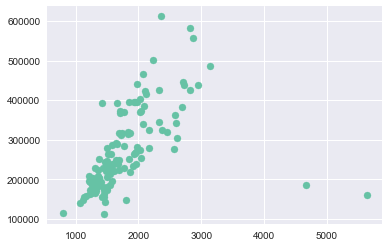

In [71]:
ax = plt.scatter(comb[(~comb['SalePrice'].isnull()) & (comb['SaleCondition']=='Partial')]['GrLivArea'], comb[(~comb['SalePrice'].isnull()) & (comb['SaleCondition']=='Partial')]['SalePrice'])
plt.show()

Other outliers below were found with similar scatter plots.

In [72]:
comb = comb[comb['TotalBsmtSF']<6000]

In [73]:
comb= comb[comb['LotArea']<150000]

In [74]:
comb = comb[comb['Id'] != 496]

In [75]:
comb = comb[comb['Id'] != 524]

This does not represent a full picture of all outliers in the data. These were found by plotting the feature importances in XGBoost, then examining scatter plots of the most important features vs SalePrice.  A more comprehensive look at outliers is sure to improve overall score.

## Model Fitting

Our model will be training to minimize _root mean squared logarithmic error_ (RMSLE). Since some of the algorithms do not include the RMSLE metric for training, we apply `np.log1p()` to `y`, then train as usual with the RMSE metric.  When we want to make a prediction, we will then apply `np.expm1()` to the predicted values from the trained model.

In [76]:
comb_d = pd.get_dummies(data=comb[interest_cols], columns = qual_cols)
y = comb['SalePrice'][~comb['SalePrice'].isnull()]
X = comb_d[~comb['SalePrice'].isnull()].drop(columns=['Id','SalePrice'])
X_p = comb_d[comb['SalePrice'].isnull()].drop(columns=['Id','SalePrice'])
logy = np.log1p(y)
X_train, X_test, y_train, y_test = train_test_split(X, logy, test_size=0.25)
dtrain = xgb.DMatrix(X,logy)

We will use several algorithms for prediction and combine their results in various ways.

#### Model selection

We use LASSO, Kernel Ridge, XGBoost, GBR, and LightGBM for model stacking and averaging. We'll use SVR as the meta-model for the stacking.

In [77]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha=0.0006))
krr = make_pipeline(StandardScaler(), KernelRidge(alpha=0.885, coef0=2.03, degree=2, gamma=None, kernel='polynomial',
      kernel_params=None))

In [78]:
xg = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.4217, gamma=0.012, learning_rate=0.005,
       max_delta_step=0, max_depth=8, min_child_weight=5.6978, missing=None,
       n_estimators=2000, n_jobs=4, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.5649,alpha=0.0666)

In [79]:
gb = GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.07, loss='huber', max_depth=3, max_features=0.17567664298921176,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=8,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=1000, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

In [80]:
lg = lgb.LGBMModel(task='train',
    boosting_type='gbdt',
    objective='regression',
    metric= 'rmse',
    num_leaves= 5,
    learning_rate= 0.05,
    feature_fraction= 0.138656590145220,
    bagging_fraction= 0.6083093498987169,
    bagging_freq= 1,
    verbose=0,
    min_data_in_leaf=3,
    n_estimators=1000)

In [81]:
svr_lin = svm.SVR(kernel='linear')
svr_rbf = svm.SVR(C=10,kernel='rbf')

The parameters for these models were obtained with [Bayesian optimization](https://github.com/fmfn/BayesianOptimization).

#### XGBoost feature importance

Examining feature importance is important for a few reasons. For one, it can tell us if our model is properly weighing features we know are important for SalePrice.  For example, total square feet is strongly associated with SalePrice. Secondly, as indicated above, outliers in the most important features can negatively affect model performance.

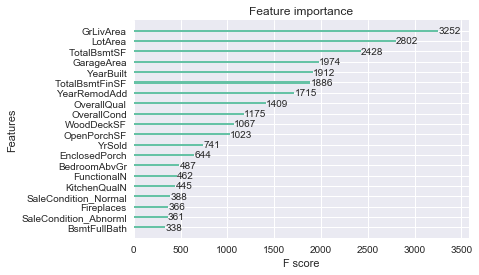

In [82]:
xg.fit(X,logy)
ax = xgb.plot_importance(xg, max_num_features=20)
plt.show()

XGBoost considers total square feet (GrLivArea) and lot area to be the most important features for prediction; this is reasonable.

#### Assessing the individual models

In [83]:
def rmsle(model):
    kfold = KFold(n_splits=5,shuffle=True).get_n_splits(X)
    scores = np.sqrt(-cross_val_score(model, X, logy, scoring='neg_mean_squared_error', cv=kfold))
    return scores

In [84]:
model_list = [xg, gb, lasso, krr, lg]
model_name = ['XGBoost', 'GBR', 'LASSO', 'KerRidge','LGB']

In [85]:
print('{:<12} | {:<12} | {:<12}'.format('Model', 'Mean RMSLE', 'StdDev'))
print('-'*45)
for i in range(len(model_list)):
    scores = rmsle(model_list[i])
    print('{:<12} | {:<12.10f} | {:<12.10f}'.format(model_name[i], scores.mean(), scores.std()))

Model        | Mean RMSLE   | StdDev      
---------------------------------------------
XGBoost      | 0.1140341240 | 0.0064270169
GBR          | 0.1144438721 | 0.0062898181
LASSO        | 0.1107230904 | 0.0052444719
KerRidge     | 0.1142399537 | 0.0057736099
LGB          | 0.1131167762 | 0.0082235959


These scores are decent.  We'd like to improve them.

#### Averaged and Stacked regression

We introduce a meta-model for stacked regression.  The idea for this borrowed from [Serigne](https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard).

In [86]:
class StackedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_model, model_list, folds=5):
        self.model_list = model_list
        self.folds = folds
        self.base_model = base_model
        
    def fit(self, X, y):
        predictions = np.zeros((X.shape[0],len(self.model_list)))
        kf = KFold(n_splits = self.folds, shuffle=True)
        self.model_list_ = [[] for _ in self.model_list]
        for idx, model in enumerate(self.model_list):
            curr_model = clone(model)
            for train_idx, test_idx in kf.split(X):
                curr_model.fit(X.iloc[train_idx],y.iloc[train_idx])
                self.model_list_[idx].append(curr_model)
                pred = curr_model.predict(X.iloc[test_idx])
                predictions[test_idx, idx] = pred
        self.base_model_ = clone(self.base_model)
        self.base_model_.fit(predictions, y)        
        return self
    
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in models]).mean(axis=1)
            for models in self.model_list_])
        return self.base_model_.predict(meta_features)

In [87]:
class AveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self,  model_list, weights):
        self.model_list = model_list
        self.weights = weights
        
    def fit(self, X, y):
        for model in model_list:
            model.fit(X,y)
        return self
    
    def predict(self, X):
        pred = []
        for model in model_list:
            pred.append(model.predict(X))
        pred = np.expm1(pred)
        ans = 0
        for i in range(len(self.weights)):
            ans += weights[i]*pred[i]
        return np.log1p(ans)

I experimented with different ways of determining the weight of each model, but in the end saw little to no benefit from assigning complicated weights.  

In [88]:
weights = [0.2,0.2,0.2,0.2,0.2]
avg_model = AveragedModels(model_list, weights)
scores = rmsle(avg_model)
print('{:<12.10f} | {:<12.10f}'.format(scores.mean(), scores.std()))

0.1072671047 | 0.0062977119


This is an improvement over the individual models. Let's evaluate the stacked model.

In [89]:
stacked = StackedModels(svr_rbf, model_list, 5)
scores = rmsle(stacked)
print('{:<12.10f} | {:<12.10f}'.format(scores.mean(), scores.std()))

0.1092597151 | 0.0064342071


I was surprised to see the stacked model perform slightly worse.  This could definitely stand improvement.

In [90]:
avg_model.fit(X,logy)
stacked.fit(X,logy)
pred_avg = np.expm1(avg_model.predict(X_p))
pred_st = np.expm1(stacked.predict(X_p))

In [91]:
res = pd.DataFrame()
res['Id'] = test['Id']
res['SalePrice'] = pred_avg
res.to_csv('house_pred.csv',index=False)

# Epilogue

As of this writing, this analysis is in the top 16% for the competition. There is certainly room for improvement in the following areas:

* A more comprehensive treatment of outliers;
* Fine-tuning the base model in stacked regression for better prediction.

Moreover, it may be worthwhile to consider the [variance inflation factor](https://en.wikipedia.org/wiki/Variance_inflation_factor).  This is available in `statsmodels.stata.outliers_influence`.